In [8]:
import pickle
import gymnasium as gym 
import os
import numpy as np
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics 
import glob

path = "/zhome/11/1/193832/resquivel/RL/Training_notebooks/data/carpole/montecarlo/"

def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)
 

In [9]:
class sarsa:
    def __init__(self, environment_name, episodes, epsilon = 0.2, alpha=0.2, gamma=0.95, adj_param = ''):
        self.env = gym.make(environment_name)
        self.episodes = episodes
        self.episode_data = 500
        self.adj_param = adj_param
        self.ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': [], 'std': [], 'mid': []}
        
        # Initialize Q
        self.space_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.number_bins = 50
        self.Q = np.random.randn(self.number_bins, self.number_bins, self.number_bins, self.number_bins, self.action_size)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.ep_rewards_t = []

    def select_e_greedy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def discretize_state(self, observation):
        pos_index = np.argmin(np.abs(np.linspace(self.lower_bounds[0], self.upper_bounds[0], num=self.number_bins).tolist() - observation[0]))
        vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[1], self.upper_bounds[1], num=self.number_bins).tolist() - observation[1]))
        ang_index = np.argmin(np.abs(np.linspace(self.lower_bounds[2], self.upper_bounds[2], num=self.number_bins).tolist() - observation[2]))
        ang_vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[3], self.upper_bounds[3], num=self.number_bins).tolist() - observation[3]))
        return pos_index, vel_index, ang_index, ang_vel_index

    def test_q(self):
        state, info = self.env.reset()
        score = 0 
        epsilon = 0.0
        d_state = self.discretize_state(state)
        action = self.select_e_greedy(d_state, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated or score > 500):
            state_prime, reward, terminated, truncated, info = self.env.step(action)
            d_state_prime = self.discretize_state(state_prime)
            action_prime = self.select_e_greedy(d_state_prime, epsilon)
            d_state = d_state_prime
            action = action_prime
            score += reward
        self.env.close()
        return score

    def train(self):
        ep_rewards = []

        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            score = 0 
            d_state = self.discretize_state(state)
            action = self.select_e_greedy(d_state, self.epsilon)
            terminated = False
            truncated = False

            while not (terminated or truncated or score > 500):
                state_prime, reward, terminated, truncated, info = self.env.step(action)
                d_state_prime = self.discretize_state(state_prime)
                action_prime = self.select_e_greedy(d_state_prime, self.epsilon)
                self.Q[d_state + (action,)] += self.alpha * (reward + self.gamma * self.Q[d_state_prime + (action_prime,)] - self.Q[d_state + (action,)])
                d_state = d_state_prime
                action = action_prime
                score += reward

            t_score = self.test_q()
            ep_rewards.append(score)
            self.ep_rewards_t.append(t_score)

            if not episode % self.episode_data:
                avg_reward = sum(self.ep_rewards_t[-self.episode_data:]) / len(self.ep_rewards_t[-self.episode_data:])
                self.ep_rewards_table['ep'].append(episode)
                self.ep_rewards_table['avg'].append(avg_reward)
                self.ep_rewards_table['min'].append(min(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['max'].append(max(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['std'].append(np.std(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['mid'].append(statistics.median(self.ep_rewards_t[-self.episode_data:]))
                
                print(f"Episode:{episode} avg:{avg_reward} min:{min(self.ep_rewards_t[-self.episode_data:])} max:{max(self.ep_rewards_t[-self.episode_data:])} std:{np.std(self.ep_rewards_t[-self.episode_data:])}")

        self.env.close()


class MonteCarlo:
    def __init__(self, environment_name, episodes, epsilon = 0.2, alpha=0.2, gamma=0.95, adj_param = ''):
        self.env = gym.make(environment_name)
        self.episodes = episodes
        self.episode_data = 500
        self.adj_param = adj_param
        self.ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': [], 'std': [], 'mid': []}
        
        # Initialize Q
        self.space_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.number_bins = 50
        self.Q = np.random.randn(self.number_bins, self.number_bins, self.number_bins, self.number_bins, self.action_size)
        self.C = np.zeros_like(self.Q)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.ep_rewards_t = []

    def select_e_greedy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def discretize_state(self, observation):
        pos_index = np.argmin(np.abs(np.linspace(self.lower_bounds[0], self.upper_bounds[0], num=self.number_bins).tolist() - observation[0]))
        vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[1], self.upper_bounds[1], num=self.number_bins).tolist() - observation[1]))
        ang_index = np.argmin(np.abs(np.linspace(self.lower_bounds[2], self.upper_bounds[2], num=self.number_bins).tolist() - observation[2]))
        ang_vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[3], self.upper_bounds[3], num=self.number_bins).tolist() - observation[3]))
        return pos_index, vel_index, ang_index, ang_vel_index

    def test_q(self):
        state, info = self.env.reset()
        score = 0 
        epsilon = 0.0
        d_state = self.discretize_state(state)
        action = self.select_e_greedy(d_state, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated or score > 500):
            state_prime, reward, terminated, truncated, info = self.env.step(action)
            d_state_prime = self.discretize_state(state_prime)
            action_prime = self.select_e_greedy(d_state_prime, epsilon)
            d_state = d_state_prime
            action = action_prime
            score += reward
        self.env.close()
        return score

    def train(self):

        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            score = 0 
            d_state = self.discretize_state(state)
            #action = self.select_e_greedy(d_state, self.epsilon)
            terminated = False
            truncated = False
            episode_states = []
            episode_actions = []
            episode_rewards = []
            
            
            while not (terminated or truncated or score > 500):
                action = self.select_e_greedy(d_state, self.epsilon)
                episode_states.append(d_state)
                episode_actions.append(action)
                
                state_prime, reward, terminated, truncated, _ = self.env.step(action)
                d_state_prime = self.discretize_state(state_prime)
                episode_rewards.append(reward)
                
                if terminated or truncated:
                    break
                
                d_state = d_state_prime

            
            G = 0
            W = 1
            for t in range(len(episode_states)):
                t = len(episode_states)-t-1
                
                state_t = episode_states[t]
                action_t = episode_actions[t]
                G = episode_rewards[t] + self.gamma * sum(episode_rewards[t+1:])
                
                self.C[state_t + (action_t,)] += W
                self.Q[state_t + (action_t,)] += W/self.C[state_t + (action_t,)] * (G - self.Q[state_t + (action_t,)])
                W = W
            

            t_score = self.test_q()
            self.ep_rewards_t.append(t_score)

            if not episode % self.episode_data:
                avg_reward = sum(self.ep_rewards_t[-self.episode_data:]) / len(self.ep_rewards_t[-self.episode_data:])
                self.ep_rewards_table['ep'].append(episode)
                self.ep_rewards_table['avg'].append(avg_reward)
                self.ep_rewards_table['min'].append(min(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['max'].append(max(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['std'].append(np.std(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['mid'].append(statistics.median(self.ep_rewards_t[-self.episode_data:]))
                
                print(f"Episode:{episode} avg:{avg_reward} min:{min(self.ep_rewards_t[-self.episode_data:])} max:{max(self.ep_rewards_t[-self.episode_data:])} std:{np.std(self.ep_rewards_t[-self.episode_data:])}")

        self.env.close()
        

class Qlearning:
    def __init__(self, environment_name, episodes, epsilon = 0.2, alpha=0.2, gamma=0.95, adj_param = ''):
        self.env = gym.make(environment_name)
        self.episodes = episodes
        self.episode_data = 500
        self.adj_param = adj_param
        self.ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': [], 'std': [], 'mid': []}
        
        # Initialize Q
        self.space_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.number_bins = 50
        self.Q = np.random.randn(self.number_bins, self.number_bins, self.number_bins, self.number_bins, self.action_size)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.ep_rewards_t = []

    def select_e_greedy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def discretize_state(self, observation):
        pos_index = np.argmin(np.abs(np.linspace(self.lower_bounds[0], self.upper_bounds[0], num=self.number_bins).tolist() - observation[0]))
        vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[1], self.upper_bounds[1], num=self.number_bins).tolist() - observation[1]))
        ang_index = np.argmin(np.abs(np.linspace(self.lower_bounds[2], self.upper_bounds[2], num=self.number_bins).tolist() - observation[2]))
        ang_vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[3], self.upper_bounds[3], num=self.number_bins).tolist() - observation[3]))
        return pos_index, vel_index, ang_index, ang_vel_index

    def test_q(self):
        state, info = self.env.reset()
        score = 0 
        epsilon = 0.0
        d_state = self.discretize_state(state)
        action = self.select_e_greedy(d_state, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated or score > 500):
            state_prime, reward, terminated, truncated, info = self.env.step(action)
            d_state_prime = self.discretize_state(state_prime)
            action_prime = self.select_e_greedy(d_state_prime, epsilon)
            d_state = d_state_prime
            action = action_prime
            score += reward
        self.env.close()
        return score

    def train(self):
        ep_rewards = []

        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            score = 0 
            d_state = self.discretize_state(state)
            #action = self.select_e_greedy(d_state, self.epsilon)
            terminated = False
            truncated = False

            while not (terminated or truncated or score > 500):
                
                action = self.select_e_greedy(d_state, self.epsilon)

                state_prime, reward, terminated, truncated, info = self.env.step(action)
                d_state_prime = self.discretize_state(state_prime)        
            
                self.Q[d_state+(action,)] += self.alpha * (reward + self.gamma * np.max(self.Q[d_state_prime]) - self.Q[d_state+(action,)])
                
                d_state = d_state_prime
                score += reward

            t_score = self.test_q()
            ep_rewards.append(score)
            self.ep_rewards_t.append(t_score)

            if not episode % self.episode_data:
                avg_reward = sum(self.ep_rewards_t[-self.episode_data:]) / len(self.ep_rewards_t[-self.episode_data:])
                self.ep_rewards_table['ep'].append(episode)
                self.ep_rewards_table['avg'].append(avg_reward)
                self.ep_rewards_table['min'].append(min(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['max'].append(max(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['std'].append(np.std(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['mid'].append(statistics.median(self.ep_rewards_t[-self.episode_data:]))
                
                print(f"Episode:{episode} avg:{avg_reward} min:{min(self.ep_rewards_t[-self.episode_data:])} max:{max(self.ep_rewards_t[-self.episode_data:])} std:{np.std(self.ep_rewards_t[-self.episode_data:])}")

        self.env.close()


In [10]:
param = "Alpha"
files = glob.glob(f"{path}*{param}*")
agent_list = []
for file in files:
    print(file)
    agent = load_object(file)
    agent_list.append(agent)

/zhome/11/1/193832/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/zhome/11/1/193832/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

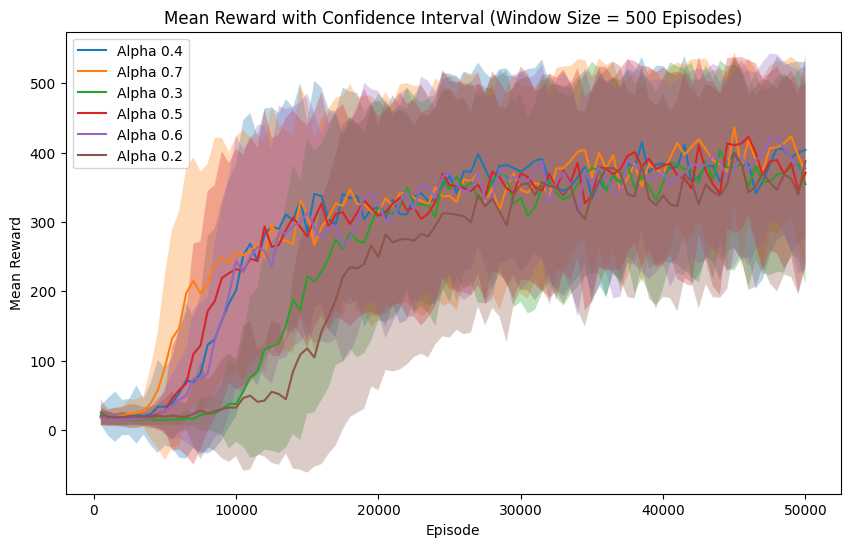

In [7]:
plt.figure(figsize=(10, 6))


for agent in agent_list:
    df = pd.DataFrame(agent.ep_rewards_table)
    # Plot the mean rewards as a main line
    sns.lineplot(data=df, x='ep', y='avg', label='Alpha '+str(agent.alpha))

    # Fill the area between (mean - std) and (mean + std) as the interval
    plt.fill_between(df['ep'], df['avg'] - df['std'], df['avg'] + df['std'], alpha=0.3)
# Customize the plot
plt.title('Mean Reward with Confidence Interval (Window Size = 500 Episodes)')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()

# Show the plot
plt.show()